# TLDR : Basic usage

From `CLI` could be run __single experiment__

`> python run_exps.py ./experiments/icdm.demo/00_main_example_exp_simpleX_ml1m_original.yaml`

...or __bunch of experiments__

`> python run_exps.py ./experiments/icdm.demo/folder_with_exps`

In [22]:
!python run_exps.py ./experiments/icdm.demo/00_main_example_exp_simpleX_ml1m_original.yaml

# Step-by-step scenario

### Step 0. Necessary imports and functions

In [1]:
import yaml
import argparse
import torch
import pandas as pd


from logging import getLogger
from pathlib import PurePath, Path
from copy import deepcopy
from recbole.data import create_dataset
from recbole.config import Config
from recbole.utils import init_logger

from utils.utils import (
    get_model,
    process_llm_emb,
    advanced_data_preparation
)
from utils.tmanager import TrainManager
from utils.journal import ExperimentsJournal

In [2]:
# for sake of Demo to not showing Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
def run_exeriment(config_file_pth):
    
    with open(config_file_pth) as file:
        config_dict = yaml.safe_load(file)  
        
        
    model_class = get_model(config_dict["model"])

    # init_seed is called automatically
    config = Config(model=model_class, config_dict=config_dict)

    if 'seed' in config:
        torch.manual_seed(config['seed'])
        
    init_logger(config)
    logger = getLogger()
    logger.setLevel(config_dict["logger_level"])
    logger.info(config)

    dataset = create_dataset(config)
    logger.info(dataset)
    datasets = advanced_data_preparation(config, deepcopy(dataset))

    expj = ExperimentsJournal(config_file_pth, dataset)
    process_llm_emb(config, dataset)  
    
    tmanager = TrainManager(config, model_class, datasets)
    tmanager.set_journal(expj)
    tmanager.run()
    tmanager.journal.save_results()
    
    return tmanager, datasets

def config_getter(exp_pth):
    if not Path(exp_pth).is_dir():
        return [Path(exp_pth)]
    
    return sorted([cfg for cfg in Path(exp_pth).iterdir() if cfg.suffix == '.yaml'])

### Step 1. Start from figuring out what is the configuration of model

Set special command to get model structure:
```
###
# Scenario Training setup
###
    scenario: 
        [
            # Part 1 Destilation
            {'print'            : 'Part #1: distilation'},
            {'set'              : {'train_part': 0}}, 
            {'init_model'       : None},
            {'reduce_dim'       : {'file_in': 'user1536.pt',  'file_out': 'user64.pt', 'dimension': 64, 'overwrite': True}},
            {'wrap_model'       : {'distil_loss': 'SimpleXUserRMSE', 'users_emb_file': 'user64.pt', 'particular': True }},
            {'set_config'       : {'epochs': 2}},
            {'init_trainer'     : None},
            {'info'             : 1},    # getting structure of model
            {'break'            : None}, # stop executing
```

This results in a description of model with the list of layers with a numbers:

```
    1 |  | root | SimpleX ()
    2 | ---- | user_emb | Embedding (6041, 128)
    3 | ---- | item_emb | Embedding (3648, 128, padding_idx=0)
    4 | ---- | UI_map | Linear (in_features=128, out_features=128, bias=False)
    5 | ---- | dropout | Dropout (p=0.1, inplace=False)
    6 | ---- | reg_loss | EmbLoss ()
```

In [4]:
exp_config_files = config_getter('./experiments/icdm.demo/00_main_example_stp1_simpleX_ml1m_original.yaml')
for exp_config_file in exp_config_files:
    print(f'Run experiment: {exp_config_file}')
    tm, dss = run_exeriment(exp_config_file)

Run experiment: experiments/icdm.demo/00_main_example_stp1_simpleX_ml1m_original.yaml
getting from: ./datasets/llm_embeddings/1_ml-1m_original/user_embs.json
   saving to: ./datasets/llm_embeddings/1_ml-1m_original/user1536.pt

Scenario execution:

stp|       command        |     output
------------------------------------------------------------------------------------
  0|               `PRINT`|
   |                      |> Part #1: distilation
------------------------------------------------------------------------------------
  1|                 `SET`|
------------------------------------------------------------------------------------
  2|          `INIT_MODEL`|
------------------------------------------------------------------------------------
  3|          `REDUCE_DIM`|
   |                      |> apply `umap` to user1536.pt -> [:64] -> user64.pt
------------------------------------------------------------------------------------
  4|          `WRAP_MODEL`|
   |              

### Step 2. Selecting the intermediate layer for distilling and debuging

Let's say, that we are interesting in the layer with number [2], specifically we would like to minimize the lost function based on it's output and prepared LLM's user embeddings.

So, for config we will set this commands:

```
###
# Scenario Training setup
###

    scenario: 
        [
            # Part 1 Destilation
            {'print'            : 'Part #1: distilation'},
            {'set'              : {'train_part': 0}}, 
            {'init_model'       : None},
            {'reduce_dim'       : {'file_in': 'user1536.pt',  'file_out': 'user64.pt', 'dimension': 64, 'overwrite': True}},
            {'wrap_model'       : {'distil_loss': 'SimpleXUserRMSE', 'users_emb_file': 'user64.pt', 'particular': True }},
            {'set_config'       : {'epochs': 2}},
            {'init_trainer'     : None},
            {'set_outputs'      : [5]}, # setting hook function on the [2] layer
            {'break'            : None},
```


In [5]:
exp_config_files = config_getter('./experiments/icdm.demo/00_main_example_stp2_simpleX_ml1m_original.yaml')
for exp_config_file in exp_config_files:
    print(f'Run experiment: {exp_config_file}')
    tm, dss = run_exeriment(exp_config_file)

Run experiment: experiments/icdm.demo/00_main_example_stp2_simpleX_ml1m_original.yaml
getting from: ./datasets/llm_embeddings/1_ml-1m_original/user_embs.json
   saving to: ./datasets/llm_embeddings/1_ml-1m_original/user1536.pt

Scenario execution:

stp|       command        |     output
------------------------------------------------------------------------------------
  0|               `PRINT`|
   |                      |> Part #1: distilation
------------------------------------------------------------------------------------
  1|                 `SET`|
------------------------------------------------------------------------------------
  2|          `INIT_MODEL`|
------------------------------------------------------------------------------------
  3|          `REDUCE_DIM`|
   |                      |> apply `umap` to user1536.pt -> [:64] -> user64.pt
------------------------------------------------------------------------------------
  4|          `WRAP_MODEL`|
   |              

#### Tips:
Now we can check how it will be works on real batch data and debug it:

In [6]:
# accessing to train data

batch = next(iter(dss[0][0]))
batch # here is our real data 

The batch_size of interaction: 64
    user_id, torch.Size([64]), cpu, torch.int64
    item_id, torch.Size([64]), cpu, torch.int64
    timestamp, torch.Size([64]), cpu, torch.float32
    label, torch.Size([64]), cpu, torch.float32
    neg_item_id, torch.Size([64]), cpu, torch.int64


In [7]:
debugs = tm.model.debug_out_hiddens(batch)
debugs

(tensor(0.9841, grad_fn=<AddBackward0>),
 {Dropout(p=0.1, inplace=False): {'input': [(tensor([[-0.0019,  0.0155,  0.0003,  ...,  0.0077, -0.0041, -0.0043],
             [-0.0124,  0.0066,  0.0078,  ..., -0.0098, -0.0071,  0.0072],
             [ 0.0044, -0.0102,  0.0019,  ..., -0.0178, -0.0005, -0.0138],
             ...,
             [-0.0034,  0.0147,  0.0030,  ...,  0.0082,  0.0044,  0.0065],
             [ 0.0094,  0.0064,  0.0033,  ..., -0.0060, -0.0026, -0.0075],
             [ 0.0003,  0.0066,  0.0062,  ..., -0.0013, -0.0001, -0.0091]],
            grad_fn=<AddBackward0>),)],
   'output': [tensor([[-0.0022,  0.0000,  0.0000,  ...,  0.0085, -0.0046, -0.0048],
            [-0.0138,  0.0073,  0.0087,  ..., -0.0109, -0.0079,  0.0000],
            [ 0.0049, -0.0113,  0.0021,  ..., -0.0197, -0.0005, -0.0153],
            ...,
            [-0.0037,  0.0164,  0.0033,  ...,  0.0091,  0.0049,  0.0072],
            [ 0.0104,  0.0071,  0.0036,  ..., -0.0066, -0.0000, -0.0083],
            [

#### Tips:
We have structure in form of:
```{
    key: {
        'input': [...], 
        'output': [...]
    }
}
```

where `key` is our layer

In [8]:
# let's check that we have an output which we expected to have:
layer_key = list(debugs[1].keys())[0]  # we could have several layers for output, here we have only one

outputs = debugs[1][layer_key]['output'] # collect outputs here
outputs[0].shape # here our details for output which we going to use for minimization

torch.Size([64, 128])

### Step 3. Parse and processing this output in module: `./models/losses.py`, applying standard losses, if need

```
class SimpleXUserRMSE(DistilLosses):    
    def __init__(
        self, 
        model, 
        llm_users_emf_file: str = None, 
        llm_items_emf_file: str = None
    ):
        super(SimpleXUserRMSE, self).__init__(model, llm_users_emf_file, llm_items_emf_file)
        
    def __call__(self, hidden_out, interaction):
        self.hidden_out = hidden_out
        self.interaction = interaction
        
        user = interaction[self.model.USER_ID]
        item = interaction[self.model.ITEM_ID]
        label = interaction[self.model.LABEL]
    
        # Parsing the output of intermediat layer

        mlp_hidden = list(self.hidden_out.keys())[0]           # get key, which is layer name
        output = self.hidden_out[mlp_hidden]['output'][0]      # apply required parsing, get desire output signal
        loss = self.rmse(output, self.llm_user_emb[user])      # apply standard loss function to output
```

### Step 4. Set up scenario for training

Feel free to set up the scenario with as many steps as we need.
Setting up the parameters which should be trained:

```
###
# Scenario Training setup
###

    scenario: 
        [
            # Part 1 Destilation
            {'print'            : 'Part #1: distilation'},
            {'set'              : {'train_part': 0}}, 
            {'init_model'       : None},
            {'reduce_dim'       : {'file_in': 'user1536.pt',  'file_out': 'user64.pt', 'dimension': 64, 'overwrite': True}},
            {'wrap_model'       : {'distil_loss': 'SimpleXUserRMSE', 'users_emb_file': 'user64.pt', 'particular': True }},
            # Available params: users_emb_file, items_emb_file
            {'set_config'       : {'epochs': 2}},
            {'init_trainer'     : None},
            {'set_outputs'      : [5]},
            {'info'             : 1},  
            {'set_trainable'    : [[2, 3, 4, 5, 6], True]},   # list of layers should be changed on True/False
            # {'set_trainable'    : [[3, 4, 5, 6], False]},  # list of layers should be changed on True/False
            {'info'             : 1},
            {'set_train_dataset': 0}, # 0 or 1, as far as there is only two options
            {'train'            : None},
            {'test_eval'        : None},

            # Part 2 Learning
            {'print'            : 'Part #2: fine-tune without distilation'},
            {'set'              : {'train_part': 1}},
            {'remove_outputs'   : None},
            {'set_trainable'    : [[2, 3, 4, 5, 6], True]},  # list of layers should be changed on True/False
            {'set_config'       : {'epochs': 2}},
            {'init_trainer'     : None},
            {'set_train_dataset': 0}, # 0 or 1, as far as there is only two options
            {'train'            : None},
            {'test_eval'        : None}
        ]
```

# Incormorated all steps

Let's run the bandle of experiments to compare two approaches:

In [19]:
exp_config_files = config_getter('./experiments/icdm.demo/bandle/')
for i, exp_config_file in enumerate(exp_config_files):
    print(f'Run experiment: {exp_config_file}')
    tm, dss = run_exeriment(exp_config_file)

Run experiment: experiments/icdm.demo/bandle/00_main_example_exp_simpleX_ml1m_original.yaml
getting from: ./datasets/llm_embeddings/1_ml-1m_original/user_embs.json
   saving to: ./datasets/llm_embeddings/1_ml-1m_original/user1536.pt

Scenario execution:

stp|       command        |     output
------------------------------------------------------------------------------------
  0|               `PRINT`|
   |                      |> Part #1: distilation
------------------------------------------------------------------------------------
  1|                 `SET`|
------------------------------------------------------------------------------------
  2|          `INIT_MODEL`|
------------------------------------------------------------------------------------
  3|          `REDUCE_DIM`|
   |                      |> apply `umap` to user1536.pt -> [:64] -> user64.pt
------------------------------------------------------------------------------------
  4|          `WRAP_MODEL`|
   |        

# Checking results

All execution is journaling with within the cruchial parameters of experiments.
Specific journal, where results of experiments will be reflected is setted into config files:
```
###
# General section
###
    ...
    journal_name: 'simplex_distils.csv'
    ...
```

In [20]:
report = pd.read_csv('./experiments/icdm.demo/bandle/simplex_distils.csv', index_col=0)[-2:].T

In [21]:
report

,1,2
subdir,icdm.demo/bandle,icdm.demo/bandle
config,00_main_example_exp_simpleX_ml1m_original.yaml,01_main_example_exp_simpleX_ml1m_original_dist...
start date,2024-10-30,2024-10-30
start time,22:10:14,22:13:34
end date,2024-10-30,2024-10-30
end time,22:13:32,22:17:38
dataset,1_ml-1m_original,1_ml-1m_original
user_num,6041,6041
item_num,3648,3648
inter_num,1000125,1000125


## Visualizations of results

In [33]:
from ast import literal_eval
import matplotlib.pyplot as plt

In [70]:
def labeling(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1*h-0.7, '%d'%int(h)+'%',
                ha='center', va='bottom', color='w')

wo_dist = literal_eval(report[1]['train_0:best_test_res'].removeprefix('OrderedDict')[1:-1])
w_dist = literal_eval(report[2]['train_1:best_test_res'].removeprefix('OrderedDict')[1:-1])
labels = [l[0] for l in wo_dist]
wo_vals= [l[1] for l in wo_dist]
w_vals= [l[1] for l in w_dist]
diff = [((d[1]-d[0])/d[1])*100 for d in zip(wo_vals,w_vals)]

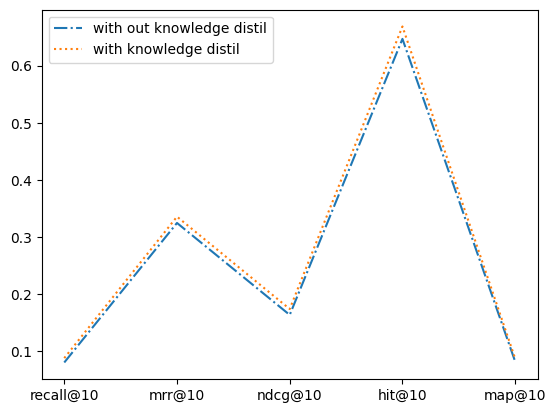

In [71]:
plt.plot(labels, wo_vals, label = "with out knowledge distil", linestyle="-.")
plt.plot(labels, w_vals, label = "with knowledge distil", linestyle=":")
plt.legend()
plt.show()

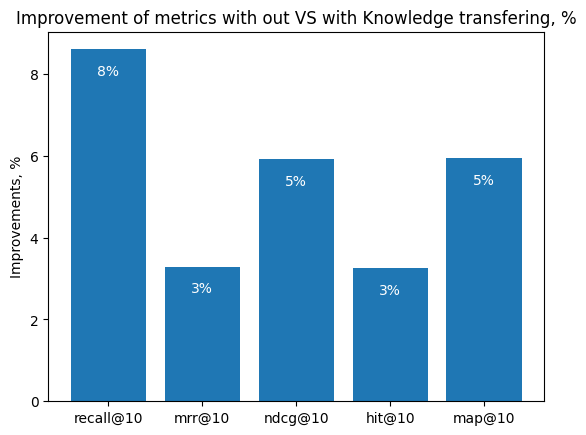

In [72]:
fig = plt.figure()
ax = fig.add_subplot(111)
bars = plt.bar(labels, diff)
labeling(bars)
_ = ax.set_ylabel('Improvements, %')
_ = ax.set_title('Improvement of metrics with out VS with Knowledge transfering, %')